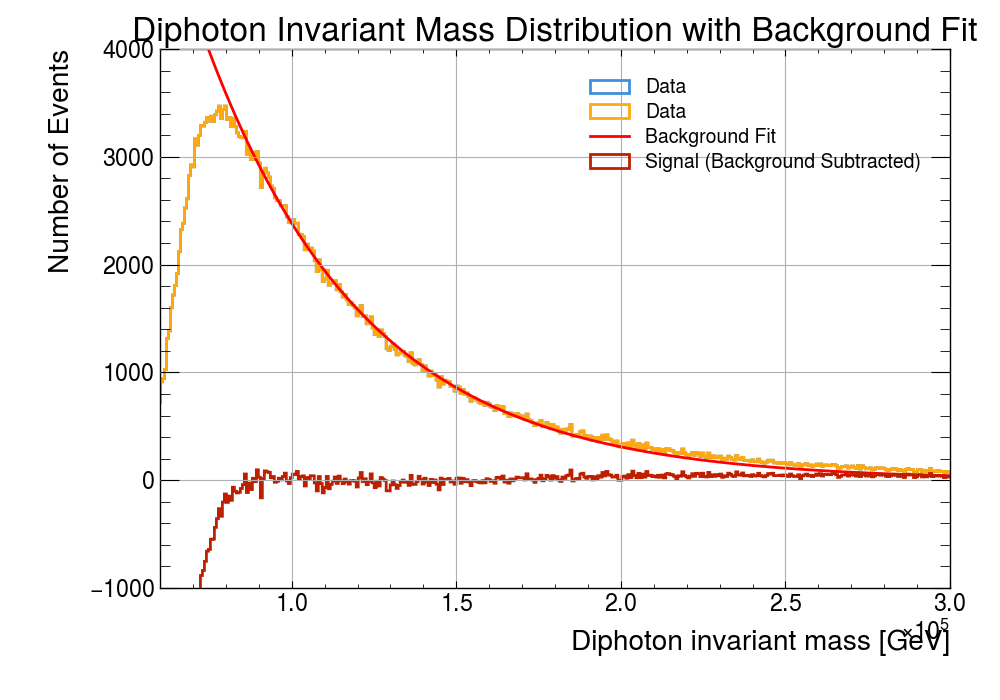

In [42]:
%matplotlib widget
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import vector

# Load the ROOT file and the tree
file = uproot.open("V:/Programme/Higgs/GamGam/Data/data_A.GamGam.root")  # replace with the correct path
tree = file["mini"]

#V:\Programme\Higgs\GamGam\Data\data_B.GamGam.root

# Extract photon transverse momentum, eta, and phi
photon_pt = tree["photon_pt"].array(library="np")
photon_eta = tree["photon_eta"].array(library="np")
photon_phi = tree["photon_phi"].array(library="np")
photon_E = tree["photon_E"].array(library="np")

# Prepare an array for storing the invariant masses
masses = []

for event in range(len(photon_pt)):
    sorted_indices = np.argsort(photon_pt[event])[::-1]  # Sort photon transverse momenta in descending order
    if len(sorted_indices) >= 2:  # Ensure there are at least two photons
        # Get the highest and second highest transverse momentum photons
        pt1, pt2 = photon_pt[event][sorted_indices[0]], photon_pt[event][sorted_indices[1]]
        eta1, eta2 = photon_eta[event][sorted_indices[0]], photon_eta[event][sorted_indices[1]]
        phi1, phi2 = photon_phi[event][sorted_indices[0]], photon_phi[event][sorted_indices[1]]
        E1, E2 = photon_E[event][sorted_indices[0]], photon_E[event][sorted_indices[1]]

        # Create four-momentum vectors for the two photons using transverse momentum
        photon1 = vector.obj(px=pt1 * np.cos(phi1), py=pt1 * np.sin(phi1), pz=pt1 * np.sinh(eta1), E=E1)
        photon2 = vector.obj(px=pt2 * np.cos(phi2), py=pt2 * np.sin(phi2), pz=pt2 * np.sinh(eta2), E=E2)
        
        # Calculate the invariant mass
        mass = (photon1 + photon2).mass
        masses.append(mass)

# Plotting the invariant mass distribution
plt.figure(figsize=(10, 7))
hist, bins, _ = plt.hist(masses, bins=5000, histtype='step', linewidth=2, label="Data")
bin_centers = (bins[:-1] + bins[1:]) / 2

# Define a polynomial function for the background
# def poly_background(x, a, b, c):
#     return a*x**2 + b*x + c

def poly_background(x, a, b):
    return a * np.exp(b * x)

param_a = 3500
param_b = 1/100000
param_c = 10

# Fit the background in a sideband region (excluding the signal region)
sideband_mask = (bin_centers > 9e4) & (bin_centers < 2e5)  # Exclude 115-135 GeV region
popt, _ = curve_fit(poly_background, bin_centers[sideband_mask], hist[sideband_mask], p0=(param_a, param_b))

# Calculate the background across the entire range
background = poly_background(bin_centers, *popt)

# Subtract the background from the original histogram
signal = hist - background



plt.hist(bin_centers, bins=bins, weights=hist, histtype='step', linewidth=2, label="Data")
plt.plot(bin_centers, background, 'r-', label="Background Fit", linewidth=2)
plt.hist(bin_centers, bins=bins, weights=signal, histtype='step', linewidth=2, label="Signal (Background Subtracted)")
plt.plot(bin_centers, poly_background(bin_centers, param_a, param_b))
plt.xlabel("Diphoton invariant mass [GeV]")
plt.ylabel("Number of Events")
plt.title("Diphoton Invariant Mass Distribution with Background Fit")
plt.xlim(6e4, 3e5)
plt.ylim(-1000, 4000)
plt.legend()
plt.grid(True)
hep.style.use("ATLAS")  # Use ATLAS style for the plot

plt.show()